# Preprocessing Part 1: Identifying images to analyze

This notebook walks through the process of pre-filtering images based on suitability for image analysis. The main criteria are:
1. Blurriness. Assuming the image is in focus, was the slide moved while taking the image? If so, skip.
2. Band integrity. Sometimes, only part of the image/bands are captured. 
3. Contrast. Does the image span the full range of brightness? For example, if only a blank background, then contrast should be low.

This notebook will help identify parameters for the steps above, and export a parameters file to use with the function, `pyroots.preprocessing_filter_loop`. 

## Import images
Import a few images:
- Blurry images
- Sharp images
- Images with missing bands

Note the `_center_image` function, which zooms in on the middle 25% of an image. Preferred for images where the middle is sharp, but the edges are blurry, which is common in photomicroscopy. 

Images


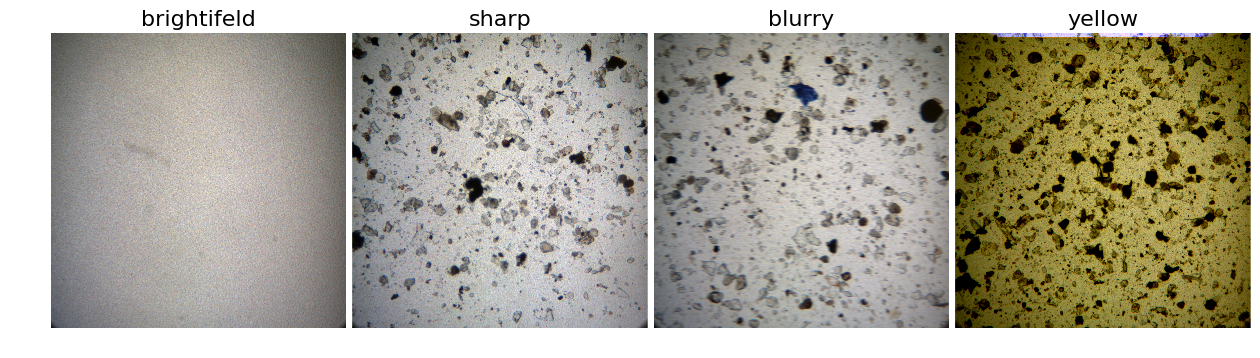


Centered Images


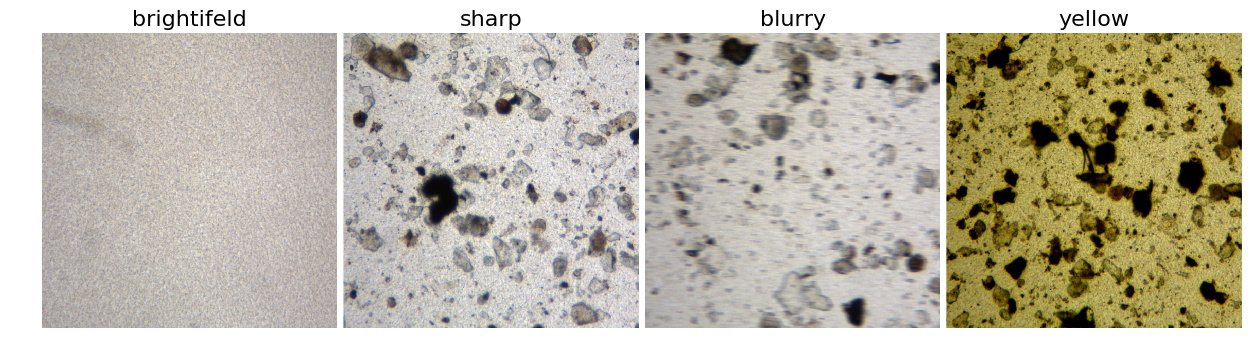

In [1]:
%matplotlib inline

#########################################################################################
dir_in = "/home/patrick/Documents/HLD Pictures Feb 2017/02-03-2017/"
bright = "BRIGHTFIELD.png"
sharp = "AA1-0001.png"
blurry = "AA1-0073.png"
blurry_1 = "AA1-0005.png"
yellow = "AE1-0742.png"    # Images with missing bands tend to be yellow on my system.
#########################################################################################
from skimage import io, img_as_ubyte, filters, color, exposure
import pyroots as pr
import cv2
import numpy as np
import os
from multiprocessing import Pool  
from multiprocessing.dummy import Pool as ThreadPool

bright = io.imread(dir_in + bright)
sharp = io.imread(dir_in + sharp)
blurry = io.imread(dir_in + blurry)
yellow = io.imread(dir_in + yellow)

centered = [pr._center_image(i) for i in [bright, sharp, blurry, yellow]]

print("Images")
img = [bright, sharp, blurry, yellow]
pr.multi_image_plot([i for i in img], ['brightifeld', 'sharp', 'blurry', 'yellow'])

print("\nCentered Images")
img = centered
pr.multi_image_plot([i for i in img], ['brightifeld', 'sharp', 'blurry', 'yellow'])

## Set parameters
Blur Parameters:
- *band*: band of rgb image to use. 
- *ratio*: comparison of edge strength in both horizontal:vertical and vertical:horizontal. high numbers are more lax. 3 should be adequate. 

Missing Band Parameters:
- *percentile*: percentile of values in a channel to set threshold
- *min_value*: minimum value of percentile in channel where the image is still concidered for analyis.

Low Contrast Parasms:
- *fraction_threshold*: Minimum fraction of luminance space an image must occupy. 

Center: Center the image before detecting blur?

/home/patrick/Programs/scikit-image/skimage/util/dtype.py:118: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


PASSES BLUR:


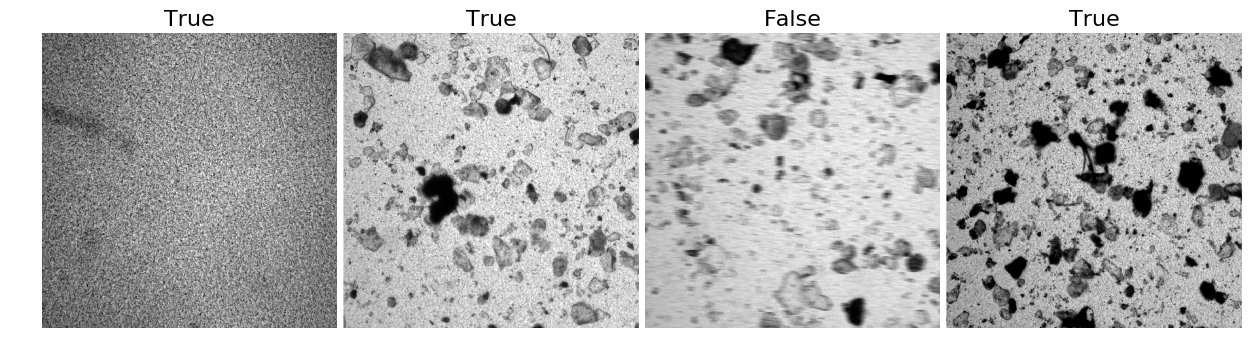


PASSES MISSING BANDS:
[True, True, True, False]

FULL FILTER:
[True, True, False, False]


In [2]:
##########################
blur_params = {'band' : 0,
               'ratio' : 3}  # semi-stringent. Higher is more stringent


temperature_params = {'percentiles'  : [40, 50, 60],  # points at which to calculate the temperature.
                      'max_distance' : 20}

low_contrast_params = {'fraction_threshold' : 0.05}  # minimum fraction of luminance space spanned by the image.
low_contrast_params = None  # recommended. 
center = True
#############################

blur = [pr.detect_motion_blur(i, **blur_params) for i in centered]
print("PASSES BLUR:")
pr.multi_image_plot([i[:, :, blur_params["band"]] for i in centered], blur)

bands = [pr.calc_temperature_distance(i, **temperature_params) for i in centered]
print("\nPASSES MISSING BANDS:")
print(bands)

if low_contrast_params is not None:
    contrast = [exposure.is_low_contrast(filters.gaussian(i, sigma=10), **low_contrast_params) for i in centered]
    print("\nPASSES LOW CONTRAST:")
    print(contrast)

full = [pr.preprocessing_filters(i, blur_params, temperature_params, low_contrast_params, center) for i in centered]
print("\nFULL FILTER:")
print(full)

## Write the parameters to a .py script

This helps document and enables the batch processing loop

In [3]:
##################
write_params_to = "/home/patrick/Documents/HLD Pictures Feb 2017/preprocessing_filters_02-15-2017.py"

write = True
# write = False
##################
dicts = ['blur_params', 'temperature_params', 'low_contrast_params', 'center']

if write is True:
    with open(write_params_to, 'w') as file:
        for i in dicts:        
            try:
                print(i + " = " + str(globals()[i]), file=file)
            except:
                print(i + " = " + str(None), file=file)
    
    print("Wrote to: " + write_params_to + "\n")
    for i in dicts:
        try:
            print(i + " = " + str(globals()[i]))
        except:
            print(i + " = " + str(None))

Wrote to: /home/patrick/Documents/HLD Pictures Feb 2017/preprocessing_filters_02-15-2017.py

blur_params = {'band': 0, 'ratio': 3}
temperature_params = {'max_distance': 20, 'percentiles': [40, 50, 60]}
low_contrast_params = None
center = True


## Run the loop on a subset of images
Make a directory for testing a subset of images to test loop parameters on a larger scale. Check results and update parameters accordingly. 

In [ ]:
pr.preprocessing_filter_loop("/home/patrick/Documents/HLD Pictures Feb 2017",  # input directory
                             ".png",                                           # extension of images to load
                             "/home/patrick/Documents/HLD Pictures Feb 2017/image filtered",     # output directory (to be made in input directory)
                             ".png",                                           # extension of images to save. lossless .png recommended.
                             write_params_to,  # path to parameters file.
                             4)

/home/patrick/Programs/scikit-image/skimage/util/dtype.py:118: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


PASSED: 02-05-2017/AQ1-0094.png
DID NOT PASS: 02-05-2017/AT1-0616.png
PASSED: 02-05-2017/AS2-0537.png
PASSED: 02-05-2017/AQ2-0219.png
PASSED: 02-05-2017/AR1-0332.png
PASSED: 02-05-2017/AQ2-0229.png
PASSED: 02-05-2017/AQ2-0208.png
PASSED: 02-05-2017/AT2-0730.png
PASSED: 02-05-2017/AS2-0481.png
PASSED: 02-05-2017/AQ2-0183.png
PASSED: 02-05-2017/AT2-0716.png
PASSED: 02-05-2017/AS2-0483.png
PASSED: 02-05-2017/AR2-0431.png
PASSED: 02-05-2017/AT2-0695.png
PASSED: 02-05-2017/AS2-0553.png
PASSED: 02-05-2017/AQ1-0104.png
PASSED: 02-05-2017/AQ1-0108.png
PASSED: 02-05-2017/AT2-0666.png
PASSED: 02-05-2017/AQ1-0032.png
PASSED: 02-05-2017/AR2-0370.png
PASSED: 02-05-2017/AR2-0455.png
PASSED: 02-05-2017/AQ1-0075.png
PASSED: 02-05-2017/AT1-0629.png
DID NOT PASS: 02-05-2017/AQ1-0003.png
PASSED: 02-05-2017/AR1-0342.png
PASSED: 02-05-2017/AR2-0357.png
PASSED: 02-05-2017/AS2-0485.png
PASSED: 02-05-2017/AR1-0283.png
PASSED: 02-05-2017/AQ1-0041.png
DID NOT PASS: 02-05-2017/AT1-0655.png
PASSED: 02-05-2017/AQ1

/usr/lib/python3/dist-packages/pyroots/preprocessing.py:58: RuntimeWarning: invalid value encountered in double_scalars
  test = horiz / vert
/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/HLD Pictures Feb 2017/image filtered/DID NOT PASS/02-05-2017/MISLOADAQ1-0099.png is a low contrast image
  warn('%s is a low contrast image' % fname)


PASSED: 02-05-2017/AR2-0358.png
DID NOT PASS: 02-05-2017/AS2-0471.png
PASSED: 02-05-2017/AS2-0510.png
PASSED: 02-05-2017/AT2-0758.png
PASSED: 02-05-2017/AR1-0237.png
PASSED: 02-05-2017/AR2-0395.png
PASSED: 02-05-2017/AR2-0443.png
PASSED: 02-05-2017/AR1-0325.png
PASSED: 02-05-2017/AQ1-0027.png
PASSED: 02-05-2017/AR1-0328.png
PASSED: 02-05-2017/AQ1-0100.png
PASSED: 02-05-2017/AR1-0282.png
PASSED: 02-05-2017/AS2-0498.png
PASSED: 02-05-2017/AT2-0703.png
PASSED: 02-05-2017/AQ1-0062.png
PASSED: 02-05-2017/AQ1-0040.png
PASSED: 02-05-2017/AQ2-0167.png
PASSED: 02-05-2017/AT1-0638.png
PASSED: 02-05-2017/AQ1-0096.png
PASSED: 02-05-2017/AQ2-0190.png
PASSED: 02-05-2017/AT1-0598.png
PASSED: 02-05-2017/AS2-0473.png
PASSED: 02-05-2017/AR1-0246.png
PASSED: 02-05-2017/AQ1-0065.png
DID NOT PASS: 02-05-2017/AT1-0605.png
PASSED: 02-05-2017/AQ2-0211.png
PASSED: 02-05-2017/AQ1-0098.png
PASSED: 02-05-2017/AR1-0293.png
PASSED: 02-05-2017/AQ2-0171.png
PASSED: 02-05-2017/AR1-0330.png
PASSED: 02-05-2017/AT1-0610.